# WORK IN PROGRESS

# Simple Example of Bayesian Modeling

<i><center>Alfred J. Reich, Ph.D.</center></i>

The focus here is on the structure of a Bayesian data model, without attempting to interpret what it means.

It is assumed that the reader has knowledge of elementary probability theory, including discrete and continuous probability distributions and densities, as well as expectations of random variables.

## Modeling Assumptions

> <i>"All models are wrong, but some are useful"</i>
> <p>-- George Box</p>

Data analyses can be categorized in terms of the assumptions made about how the data being analyzed are probabilistically modeled. Broadly speaking, there are three categories, or levels, of assumptions (listed below) where, at each level, assumptions increase -- and so does the possibility that the added assumptions are wrong.

<b>1. Exploratory Data Analysis</b> -- No probability model; just descriptive statistics
> Examples include: Average, Median, Quantiles, Range, Variance, Minimum/Maximum, Histogram, and various other plots and charts

<b>2. Classical Data Analysis</b> -- Probability model with fixed parameter

>$$X \sim F(x;\theta)$$
><p>Assumes a random variable, $X$, with a probability distribution, $F$, and a fixed parameter, $\theta$. (The quantities here can be scalars or vectors.)

<b>3. Bayesian Data Analysis</b> -- Probability model with random parameter that has its own model

>$$X \sim F(x;\Theta)$$
><p>$$\Theta \sim G(\theta;\gamma)$$</p>
><p>Assumes a random variable, $X$, with a probability distribution, $F$, and
>random parameter, $\Theta$, with its own distribution, $G$, and (usually) fixed parameter, $\gamma$, called a hyperparameter. (Again, the quantities here can be scalars or vectors.)
><p>$G$ is called a <b><i>prior</i></b> distribution.</p>

## An Example

Suppose we conduct a real-world experiment consisting of:
* a series of $n$ independent trials,
* where each trial results in either a <i>Success</i> or <i>Failure</i>,
* and the probability of a Success on any one trial is an unknown value, $\theta$, where $0 \le \theta \le 1$,
* and the outcome of the experiment is the total number of successful trials, $K$, out of $n$ trials.

This type of experiment follows a <b>Binomial</b> probability model. Also, $n$ is not a parameter; it is a known, fixed value that represents the number of observations (trials) we make.

>$$K \sim Binomial_n(k; \theta) = \binom{n}{k} \theta^k(1-\theta)^{n-k}$$
><p>where</p>
><p>$k \in \{0,1,2,...,n\}$ -- Number of successes in n trials (the outcome)</p>
><p>$\theta \in [0,1]$ -- The probability of success for each trial</p>
><p>$n \in \{1,2,3,...\}$ -- The fixed number of trials conducted</p>

Suppose further that, after conducting the $n$ trials, we observed a total of $K=k_{obs}$ successes. $0 \le k_{obs} \le n$.

We don't know the value of $\theta$, but let's assume, for this example, that $n$ and $k_{obs}$ have the following values:

In [5]:
n = 20  # Number of trials in our real-world experiment
k_obs = 6  # Number of observed successes in our real-world experiment

In [6]:
print(f"Then, a \"reasonable\" estimate of p is k_obs/n = {k_obs}/{n} = {k_obs/n}")

Then, a "reasonable" estimate of p is k_obs/n = 6/20 = 0.3


In <i>Classical</i> (<i>Frequentist</i>) data analysis, this estimate is the <i>Maximum Likelihood Estimate (MLE)</i> of $\theta$.  We won't go into MLEs here, but let's just say that the MLE provides us with, in a Frequentist sense, an optimal estimate of a deterministic parameter.

### A Single Simulation Experiment

Since we're dealing with random behavior here, any value of $\theta$, where $0 \lt \theta \lt 1$, could result in $k_{obs}$ successes.

Some values of $\theta$ will be more likely to produce $k_{obs}$ successes than other values.

So, let's see what happens when we generate a single <i>Uniform(0,1)</i> random value, $\theta$, and then use it to generate a single $Binomial_n(k; \theta)$ random value, $k$, which should approximate the expectation of $K$:
<p>$$E[K]=n\theta$$

Here are the calculations:

In [7]:
from scipy.stats import uniform, binom

theta = uniform.rvs()  # generates a single Uniform(0,1) random value, theta
k = binom.rvs(n, theta) # uses theta to generate a single Binomial(n, theta) random value

print(f"\nRandom Uniform(0,1) ==> {theta:0.3f}")
print("                          |")
print("                          |")
print("                          |")
print(f"    Random Binomial({n}, {theta:0.3f}) ==> k = {k} successes; expected {int(round(n*theta))} ({theta:0.3f} x {n})")


Random Uniform(0,1) ==> 0.814
                          |
                          |
                          |
    Random Binomial(20, 0.814) ==> k = 19 successes; expected 16 (0.814 x 20)


But, what we're really interested in are values of $\theta$ that, when used in a $Binomial_n(k;\theta)$ trial, yield a result that matches $K = k_{obs}$, our previously observed number of successes.

So, we'll repeat what we just did, except that we'll do it many times over.

### Approximating a Conditional Probability using Simulation

> <i>"We could call Bayesian data analysis 'statistics using conditional probability', but that wouldn’t put the butts in the seats."</i>  
> <p>-- Andrew Gelman</p>

Now, we'll try more values of $\theta$ -- a lot more values -- and keep track of the ones that result in $k_{obs}$ successes.  Essentially, we're assuming that our <i>Prior</i> model is the <i>Uniform(0,1)</i> distribution, and what we'll obtain is an approximation to the conditional probability density of $\Theta$ given that $K=k_{obs}$ (i.e., the <i>Posterior</i>):

$$P(\theta | K = k_{obs})$$

To do this, we'll work with two lists of $\theta$'s:

* <b><i>priors</i></b>: a list of $m$ independent <i>Uniform(0,1)</i> random numbers

* <b><i>posteriors</i></b>: the subset of priors that, when used in a $Binomial_n(k;\theta)$ trial, result in $k_{obs}$ successes

The code that calculates these two lists is below. (<i>Note: The code is pedagogical, not practical.  Farther below, we'll show how to use a more efficient simulation method.)</i>

#### Computing the Priors and Posteriors

Effectively, only 2 lines of code are required.  One to compute the priors and one to compute the posteriors.  The 2nd line of code is the key calculation in this example.

In [8]:
from scipy.stats import uniform, binom

m = 500_000  # Number of priors
priors = uniform.rvs(size=m)

# If the number of priors is high, then the calculation of the posteriors
# could take some time, so we'll time it.
%time posteriors = [theta for theta in priors if binom.rvs(n,theta)==k_obs]

print(f"\nThere were {len(posteriors)} matches out of {m} priors. (Only {100*len(posteriors)/m:0.2}% matched)")

CPU times: user 15.8 s, sys: 193 ms, total: 16 s
Wall time: 15.8 s

There were 24114 matches out of 500000 priors. (Only 4.8% matched)


Now, let's look at the two lists, plotted as histograms and scaled to be density functions.

#### Priors Histogram

The histogram of the priors list should look like the Uniform(0,1) probabilty density function; and it does.

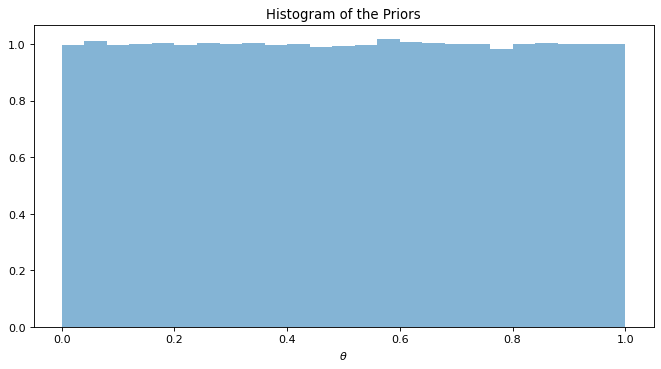

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

hbins = 25  # Number of bins for histograms
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta$")
plt.title("Histogram of the Priors")
_ = plt.hist(priors, bins=hbins, density=True, range=[0.0, 1.0], alpha=0.55)

#### Posteriors Histogram

The histogram of the posteriors list more interesting.  It approximates the probability density of the conditional random variable, $\Theta | K=k_{obs}$.

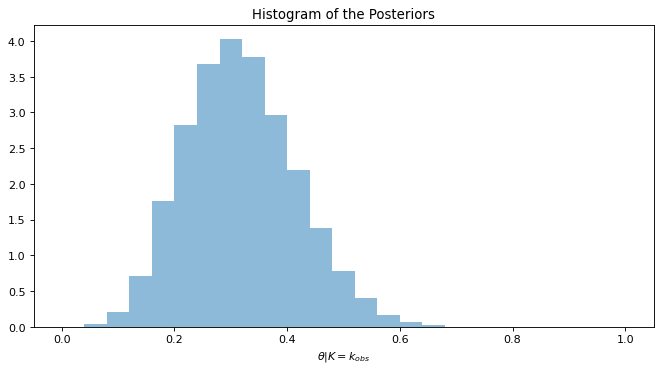

In [10]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta | K = k_{obs}$")
plt.title(f"Histogram of the Posteriors")
_ = plt.hist(posteriors, bins=hbins, density=True, range=[0.0, 1.0], alpha=0.5)

In the histogram, above, we can see that the posterior values of $\theta$ concentrate near the MLE value we computed earlier.

But, unlike the MLE, which is a point estimate of $\theta$, here we see a probability density for $\theta$.

And we should, because we assumed that $\theta$ is a random variable.

### A Closer Look at the Posterior

I turns out that, for the example we've just gone through, the posterior distribution can be computed exactly by analytical means, instead of simulation. Before we show that we'll do a bit of exploratory analysis on the posterior list using some (gasp) frequentist tools, such as MLE's, p-values. (the horror ...)

To begin, the prior values, computed above, came from the Uniform(0,1) distribution, a continuous distribution.  So, the posterior values are also from a continuous distribution. But we don't know what that distribution is, or even whether it conforms to some known distribution. The <i>SciPy.stats</i> library supports over 90 continuous distributions.  In this section we'll "sift" through a subset of those 90 distributions to find one that best fits the posterior data. We can do that by using a module called <i>[fitdist](https://github.com/alreich/fitdist)</i>. The input to fitdist is a sequence of scalar data and its output is a list of the best-fitting continuous distributions to that data.  The best-fitting distributions are ordered by goodness of fit and only the few top distributions are returned.

In [61]:
import fitdist as fd  # https://github.com/alreich/fitdist
import warnings
warnings.simplefilter('ignore')

best_fit_results = fd.find_best_fit_distributions(posteriors,
                                                  dist_names = fd.common_cont_dist_names,
                                                  goodness_of_fit_pvalue = 0.10,
                                                  drop_dist_names = []
                                                 )

best_fit_results

[['beta',
  (8.011507144616559,
   18.558183337533208,
   -0.017384465867395327,
   1.1131730113120129),
  0.8497446000766494],
 ['powernorm',
  (0.1472779190478713, 0.19569472325506315, 0.0492755080042131),
  0.5503279365802047],
 ['genextreme',
  (0.17561190761107792, 0.27939444438558814, 0.09097343201810747),
  0.5067025710130266],
 ['exponweib',
  (1.9389537144261537,
   2.4055574831513704,
   0.015313487415693662,
   0.2756579611507427),
  0.4153622843694954]]

As we can see from the <i>best_fit_results</i> returned, above, the <b>beta</b> distribution best fits the posterior data.  We can pull out the best-fitting MLE parameter estimates, and round them a bit for readability:

In [86]:
best_index = 0
best_name = best_fit_results[best_index][0]
best_mle = best_fit_results[best_index][1]
best_mle = tuple(map(lambda x: round(x,2), best_mle))
best_shape_a, best_shape_b, best_location, best_scale = best_mle
print(f"Best MLE fit to posteriors: {best_name}({best_shape_a},{best_shape_b}) over the interval [{best_location}, {best_scale}])")

Best MLE fit to posteriors: beta(8.01,18.56) over the interval [-0.02, 1.11])


Here are the posterior histogram and the best fitting distribution, plotted together:

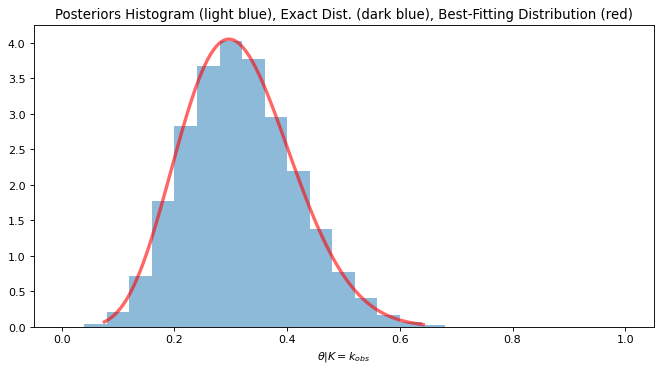

In [87]:
from scipy.stats import beta
import numpy as np

x = np.linspace(beta.ppf(0.001, *best_mle), beta.ppf(0.999, *best_mle), 100)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta | K = k_{obs}$")
plt.title(f"Posteriors Histogram (light blue), Exact Dist. (dark blue), Best-Fitting Distribution (red)")
plt.plot(x, beta.pdf(x, *best_mle), 'r-', lw=3, alpha=0.6, label=best_name)
_ = plt.hist(posteriors, bins=hbins, density=True, range=[0.0, 1.0], alpha=0.5)

## What Does Theory Say?

In [80]:
best_dist = beta(*best_mle)
exact_dist = beta(*exact_mle)

In [83]:
print(best_dist.mean())
print(best_dist.median())

0.31462928114414757
0.3090283097431845


In [79]:
best_dist.interval(0.95)

(0.14224173962858036, 0.518397172733949)

In [82]:
best_dist.pdf(x)

array([0.06881009, 0.09357988, 0.12438897, 0.16197758, 0.20704121,
       0.26020845, 0.32202017, 0.39291066, 0.47319143, 0.56303782,
       0.66247914, 0.77139214, 0.88949818, 1.01636388, 1.15140526,
       1.29389508, 1.44297304, 1.5976587 , 1.75686647, 1.91942245,
       2.08408261, 2.24955189, 2.41450375, 2.57759987, 2.73750939,
       2.89292767, 3.04259388, 3.18530744, 3.31994287, 3.44546306,
       3.56093056, 3.66551707, 3.75851085, 3.83932216, 3.90748673,
       3.96266725, 4.00465311, 4.03335829, 4.04881777, 4.05118241,
       4.04071263, 4.0177709 , 3.98281338, 3.93638075, 3.87908857,
       3.81161714, 3.7347012 , 3.6491196 , 3.55568499, 3.45523378,
       3.34861642, 3.23668817, 3.12030034, 3.00029225, 2.87748378,
       2.75266873, 2.62660886, 2.50002877, 2.37361158, 2.2479953 ,
       2.12377008, 2.00147611, 1.88160229, 1.76458552, 1.65081064,
       1.54061093, 1.43426912, 1.33201887, 1.23404662, 1.14049387,
       1.05145961, 0.96700314, 0.88714691, 0.81187961, 0.74115

><i>(Note: For this specific example, simulation is not needed at all, because the posterior density can be computed analytically.)</i>

SPOILER ALERT: According to theoretical results, that we haven't spoken about yet, the best fitting distribution should be the <b>beta</b> distribution.

More on the beta distribution can be found at the [SciPy beta distribution documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html) or on [Wikipedia's beta distribution page](https://en.wikipedia.org/wiki/Beta_distribution).

The <b>Uniform(0,1)</b> prior, used above, is equivalent to a <b>Beta(1,1)</b> prior.  And, since the beta prior is conjugate with binomial likelihoods, the posterior should be a <b>Beta( 6 + 1, 20 - 6 + 1 ) = Beta(7,15)</b> which is close to what we obtained above.

Here's the math:

First of all, the Uniform distribution is equivalent to a Beta distribution:
<p><center>$U(0,1) \equiv Beta(1,1)$</center></p>
<p>Then, assuming the <i>prior</i> and the <i>likelihood</i> are as follows:</p>
<p><center><u>Prior</u>:  $\pi(\theta) \sim Beta(\alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$</center></p>
<p><center><u>Likelihood</u>:  $K \sim Binomial(n,k,\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$</center></p>
<p>So, multiplying the two, followed by some algebraic manipulation, we arrive at:</p>
<p><center><u>Posterior</u>:  $\pi(\theta \mid K=k) \sim Beta(k+\alpha, n-k+\beta)$</center></p>

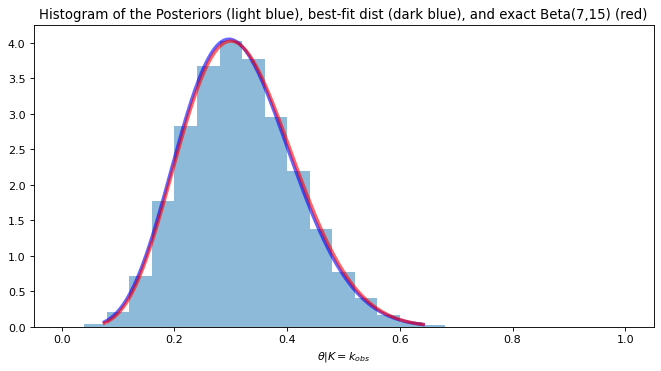

In [60]:
exact_mle = (7, 15, 0, 1)

fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta | K = k_{obs}$")
plt.title(f"Histogram of the Posteriors (light blue), best-fit dist (dark blue), and exact Beta(7,15) (red)")
plt.plot(x, beta.pdf(x, *best_mle), 'b-', lw=3, alpha=0.6, label=best_name)
plt.plot(x, beta.pdf(x, *exact_mle), 'r-', lw=3, alpha=0.6, label=best_name)
_ = plt.hist(posteriors, bins=hbins, density=True, range=[0.0, 1.0], alpha=0.5)

### Using PyMC3

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:03<00:00, 11859.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
/Users/alfredreich/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/alfredreich/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/alfredreich/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argume

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4c92a6b50>,
      dtype=object)

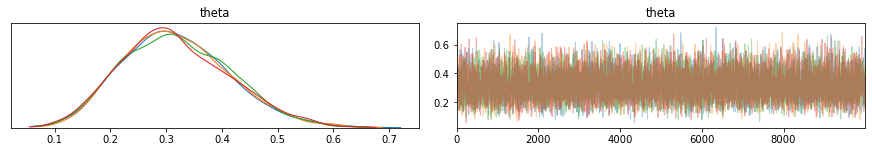

In [23]:
import pymc3 as pm

model = pm.Model()

with model:
    theta = pm.Beta("theta", alpha=1, beta=1 )
    k = pm.Binomial("k", p=theta, n=n, observed=k_obs)
    num_samples = 10_000
    tr = pm.sample(num_samples, step=pm.Metropolis(), progressbar=True )
    #tr = pm.sample(num_samples, progressbar=True )

pm.traceplot(tr)

In [24]:
model

In [25]:
frac = 0.8
int(frac * num_samples)

8000

In [26]:
len(tr['theta'])

40000

In [27]:
theta_samples = tr['theta', 2000:]

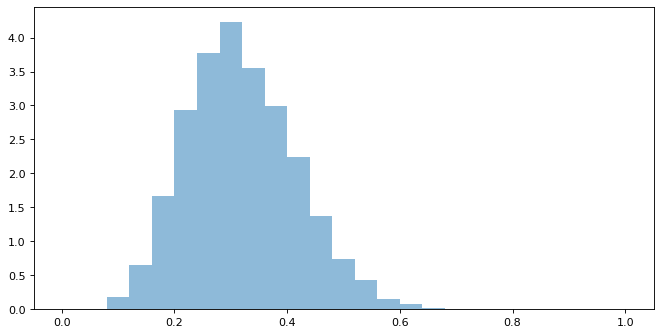

In [28]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
_, _, _ = plt.hist(theta_samples, hbins, density=True, range=[0.0, 1.0], alpha=0.5)

In [29]:
map_estimate = pm.find_MAP(model=model)
map_estimate['theta']

logp = -3.2978, ||grad|| = 4: 100%|██████████| 6/6 [00:00<00:00, 1690.12it/s]


array(0.29999954)

In [30]:
import fitdist as fd

pymc3_fit_results = fd.find_best_fit_distributions(theta_samples,
                                                   dist_names = fd.common_cont_dist_names,
                                                   goodness_of_fit_pvalue = 0.10,
                                                   drop_dist_names = []
                                                  )

pymc3_fit_results

[]

In [31]:
pm_index = 0
pm_name = pymc3_fit_results[pm_index][0]
pm_mle = pymc3_fit_results[pm_index][1]
pm_mle_rounded = tuple(map(lambda x: int(round(x)), pm_mle))
pm_shape_a, pm_shape_b, pm_location, pm_scale = pm_mle_rounded
print(f"PyMC3 Fit to sampled data: {pm_name}({pm_shape_a},{pm_shape_b}) over the interval [{pm_location}, {pm_scale}])")

IndexError: list index out of range

# Scratch Work Below

$\theta$, here it is assumed to be a random variable, $\Theta$, with its own distribution, a <b>Beta distribution</b>, $Beta(\theta; \alpha, \beta)$, where $\theta \in [0,1]$, $\alpha > 0$, and $\beta > 0.$

$\Theta \sim Beta(\theta; \alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$

$K \sim Binomial_n(k; \theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$

> <p>where</p>
> <p>$n \in \{1,2,3,...\}$ -- Number of trials (a fixed value)</p>
> <p>$k \in \{0,1,2,...,n\}$ -- Number of successes</p>
> <p>$\theta \in [0,1]$ -- The fixed probability of success for each trial
> <p>$\alpha > 0$ and $\beta > 0$</p>

In [4]:
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()